In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.layers import *
from keras.models import *
from keras.losses import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

### Step 1: Loading in the data

In [ ]:
train_zip_path = '/kaggle/input/facial-keypoints-detection/training.zip'
test_zip_path = '/kaggle/input/facial-keypoints-detection/test.zip'
Id_table_path = '/kaggle/input/facial-keypoints-detection/IdLookupTable.csv'
sample_sub_path = '/kaggle/input/facial-keypoints-detection/SampleSubmission.csv'
extracted_files_path = '/kaggle/working'

In [ ]:
#Unzip train csv file to 'extracted_files_path'.
import zipfile
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)
#Unzip test csv file to 'extracted_files_path'.
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)

In [ ]:
#Read train csv file.
train_csv = pd.read_csv(extracted_files_path + '/training.csv')
#Read test csv file.
test_csv = pd.read_csv(extracted_files_path + '/test.csv')
#Read IdLookUpTable csv file.
looktable_csv = pd.read_csv(Id_table_path)

In [ ]:
train_csv.fillna(method = 'ffill',inplace = True)

In [ ]:
#Transform the data into images and plot one to see

imgs = []
for i in range(0,7049):
    img = train_csv['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imgs.append(img)


image_list = np.array(imgs,dtype = 'float')
X_train = image_list.reshape(-1,96,96,1)
plt.imshow(X_train[0].reshape(96,96),cmap='gray')
plt.show()

In [ ]:
#Get the keypoint labels
training = train_csv.drop('Image',axis = 1)

y_train = []
for i in range(0,7049):
    y = training.iloc[i,:]

    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

#Plot labels ontop of image
img = X_train[0].copy()
for i in range(0, len(y_train[0])-1, 2):
    x = int(y_train[0][i])
    y = int(y_train[0][i+1])
    plt.scatter(x,y)
plt.imshow(img.reshape(96,96),cmap='gray')

### Step 2: Creating the Heatmaps
* So how do we actually get our labelled heatmap data? Turns out it is actually quite easy, we simply pass our Cartesian coordinates through a 2D gaussian kernel.

In [ ]:
#(x,y)keypoint를 통해 2D 가우스 커널을 convoluting하여 히트맵을 생성하는 함수
def gaussian(xL, yL, H, W, sigma=5):

    channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
    channel = np.array(channel, dtype=np.float32)
    channel = np.reshape(channel, newshape=(H, W))

    return channel

In [ ]:
#하나의 샘플 이미지에 대한 히트맵 생성
heatmaps = []

for i in range(0, 30, 2):
    x = int(y_train[0][i])
    y = int(y_train[0][i + 1])
    heatmap = gaussian(x, y, 96, 96)
    heatmaps.append(heatmap)
    
heatmaps = np.array(heatmaps)

plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(heatmaps[0])
plt.title("Single Heatmap")

plt.subplot(1,4,2)
plt.imshow(heatmaps.sum(axis=0))
plt.title("All Heatmaps added Together")

plt.subplot(1,4,3)
plt.imshow(np.squeeze(X_train[0], axis=2), cmap='gray')
plt.title("Input Image")

plt.subplot(1,4,4)
for i in range(0, len(y_train[0])-1, 2):
    x = int(y_train[0][i])
    y = int(y_train[0][i+1])
    plt.scatter(x,y)
plt.imshow(X_train[0].reshape(96,96), cmap='gray')
plt.title("Image with Keypoints")
plt.show()

heatmaps.shape

* 데이터 셋에 따르면, 각 입력 이미지는 그것과 관련된 15개의 keypoint를 가지고 있다. 따라서 각 이미지에는 15 개의 히트 맵이 있으며 각 얼굴 키포인트마다 1 개의 히트 맵이 있다. 위의 그림에서 볼 수 있듯이, 조금 더 노란색인 히트맵 영역은 keypoint 위치에 더 가까운 픽셀을 나타낸다.

### Step 3: Keras Custom Generator

* training 중에 즉시 heatmap 데이터 배치를 산출할 수 있는 Keras Custom Generator를 만들 것이다.

* keras.utilities.Sequence를 상속하는 새로운 파이썬 클래스를 만들 것이다. 

1) __init__(): 기본적인 초기화 방법

2) on_properch_end(): generator가 데이터의 한 시대를 통과할 때마다 트리거된다. 일반적으로 이 방법을 사용하여 데이터 셋을 shuffle할 수 있다.

3) __data_generation(): 실제로 데이터 처리를 하는 방법, 여기서 데이터 배치를 생성

4) __len__():  generator에 하나의 전체 시대를 완료하는 데 필요한 데이터 배치 수를 알려주기 위해 사용되며, 0과 총 배치 수 사이의 인덱스를 반환한다. 

5) __get_item__(): 실제로 데이터 배치를 반환하는 방법

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, imgs, kps, batch_size=32, shuffle=True):
        self.imgs = imgs
        self.kps = kps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.imgs) // self.batch_size

    def __getitem__(self, index):
        #Get index of images to generate
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        #Shuffle the data after the generator has run through all samples
        self.indexes = np.arange(len(self.imgs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def gaussian(self, xL, yL, H, W, sigma=5):
        ##Function that creates the heatmaps##
        channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
        channel = np.array(channel, dtype=np.float32)
        channel = np.reshape(channel, newshape=(H, W))

        return channel

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        X_batch = [self.imgs[i] for i in indexes]
        X_batch = np.array(X_batch)
        
        y_batch = []
        
        kps = [self.kps[i] for i in indexes]
        
        for i in range(0,len(kps)):
            heatmaps = []
            for j in range(0, 15):
                x = int(kps[i][j*2])
                y = int(kps[i][j*2+1])
                heatmap = self.gaussian(x, y, 96, 96)
                heatmaps.append(heatmap)
            y_batch.append(heatmaps)
                
        y_batch = np.array(y_batch)
        y_batch = np.swapaxes(y_batch,1,3)
        y_batch = np.swapaxes(y_batch,1,2)
        return X_batch, [y_batch, y_batch]

In [ ]:
#Testing to see if our DataGenerator is working
X_batch, [y_batch, _] = next(DataGenerator(X_train, y_train).__iter__())
print(X_batch.shape)
print(y_batch.shape)

#Plot a single image overlayed with its heatmaps
plt.imshow(X_batch[0].reshape(96,96), cmap='gray', alpha=0.5)
plt.imshow(y_batch[0].sum(axis=2), alpha=0.5)

* 이것은 우리가 intermediate training과 함께 2단계 히트맵 회귀 접근법을 사용할 것이기 때문에 의도적으로 행해진 것이다. 기본적으로 모든 단계는 히트맵을 예측하고 다음 단계는 입력 이미지와 함께 이전 단계의 히트맵 예측을 사용하여 보다 정확하고 새로운 예측을 생성한다.

* 우리가 분명히 밝혀야 할 한 가지는 intermediate training이다. 모델을 만들면 만들수록 더 많은 layers를 갖게 되므로 모델이 Vanishing Gradient Problem에 직면할 수 있다. 이에 대처하기 위해 우리는 모델의 총 손실이 각 개별 단계의 손실을 합산하는 intermediate training을 사용할 것이다.

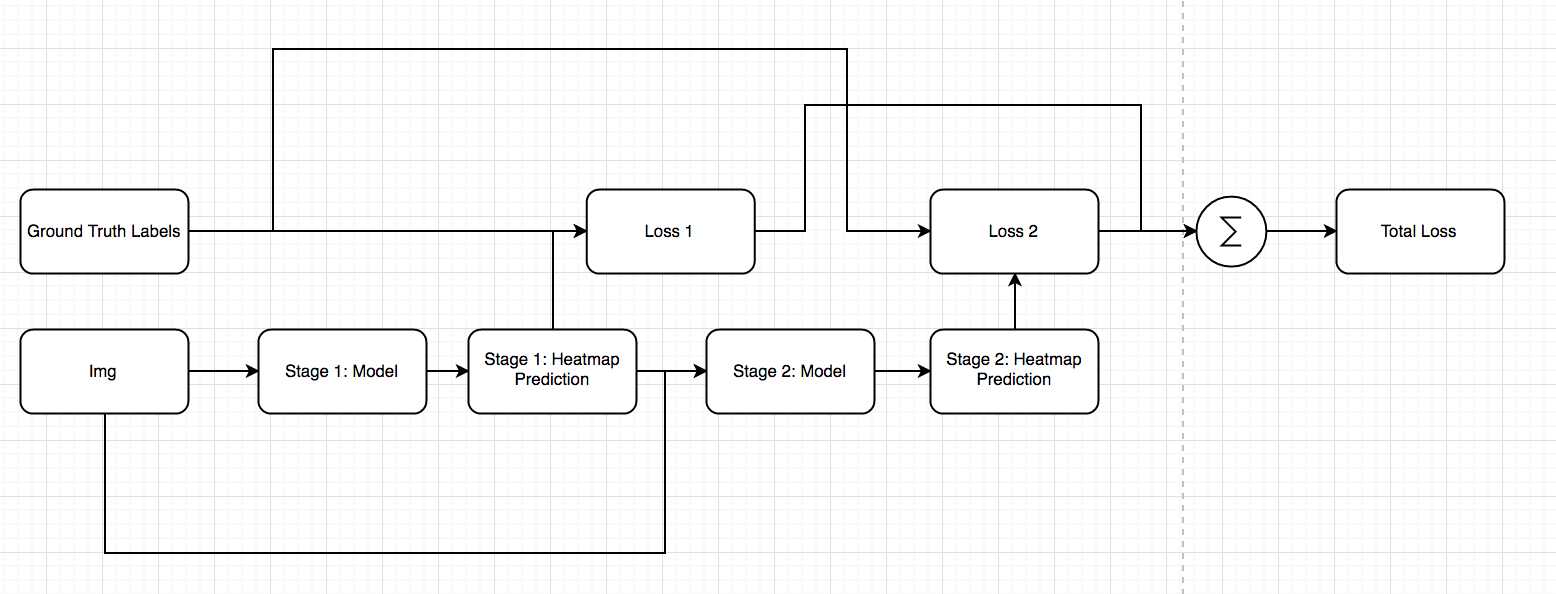

### Step 4: Creating the Model

In [ ]:
#Helper function for building model
def conv_block(x, nconvs, n_filters, block_name, wd=None):
    for i in range(nconvs):
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   kernel_regularizer=wd, name=block_name + "_conv" + str(i + 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name=block_name + "_pool")(x)
    return x
  
#Represents one stage of the model
def stages(x, stage_num, num_keypoints = 15):
  
    #Block 1
    x = conv_block(x, nconvs=2, n_filters=64, block_name="block1_stage{}".format(stage_num))
  
    #Block 2
    x = conv_block(x, nconvs=2, n_filters=128, block_name="block2_stage{}".format(stage_num))
  
    #Block 3
    pool3 = conv_block(x, nconvs=3, n_filters=256, block_name="block3_stage{}".format(stage_num))
  
    #Block 4
    pool4 = conv_block(pool3, nconvs=3, n_filters=512, block_name="block4_stage{}".format(stage_num))
  
    #Block 5
    x = conv_block(pool4, nconvs=3, n_filters=512, block_name="block5_stage{}".format(stage_num))
  
    #Convolution 6
    x = Conv2D(4096, kernel_size=(1, 1), strides=1, padding="same", activation="relu", name="conv6_stage{}".format(stage_num))(x)
  
    #Convolution 7
    x = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", activation="relu", name="conv7_stage{}".format(stage_num))(x)

    #upsampling
    preds_pool3 = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", name="preds_pool3_stage{}".format(stage_num))(pool3)
    preds_pool4 = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", name="preds_pool4_stage{}".format(stage_num))(pool4)
    up_pool4 = Conv2DTranspose(filters=15, kernel_size=2, strides=2, activation='relu', name="ConvT_pool4_stage{}".format(stage_num))(preds_pool4)
    up_conv7 = Conv2DTranspose(filters=15, kernel_size=4, strides=4, activation='relu', name="ConvT_conv7_stage{}".format(stage_num))(x)
  
    fusion = Add()([preds_pool3, up_pool4, up_conv7])
  
    heatmaps = Conv2DTranspose(filters=15, kernel_size=8, strides=8, activation='relu', name="convT_fusion_stage{}".format(stage_num))(fusion)
    heatmaps = Conv2D(num_keypoints, kernel_size=(1, 1), strides=1, padding="same", activation="linear", name="output_stage{}".format(stage_num))(heatmaps)
    return heatmaps
  
#Create a single stage FCN
def build_model(input_shape):
    outputs = []
  
    img = Input(shape=input_shape, name="Input_stage")
  
    ### Stage 1 ###
    heatmaps1 = stages(img, 1)
    outputs.append(heatmaps1)
  
    ### Stage 2 ###
    x = Concatenate()([img, heatmaps1])
    heatmaps2 = stages(x, 2)
    outputs.append(heatmaps2)
  
    model = Model(inputs=img, outputs=outputs, name="FCN_Final")
    return model

In [ ]:
#Training the model using mean squared losss
def get_loss_func():
    def mse(x, y):
        return mean_squared_error(x,y)
  
    keys = ['output_stage1', 'output_stage2']
    losses = dict.fromkeys(keys, mse)
    return losses

model = build_model((96,96,1))
losses = get_loss_func()
model.compile(loss = losses, optimizer = 'adam')
model.summary()

### Step 5: Training the Model

In [ ]:
#First, lets split the data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

#Create your two generators for train and validation
gen_train = DataGenerator(X_train, y_train)
gen_val = DataGenerator(X_val, y_val)

#Train the model
model.fit_generator(generator = gen_train,
                    epochs = 10,
                    validation_data = gen_val)

In [ ]:
X_batch, [y_batch, _] = next(gen_val.__iter__())

index = np.random.randint(0,32)

predictions = model.predict(X_batch)

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(y_batch[index].sum(axis=2))
plt.title("Ground Truth Heatmap")

plt.subplot(1,4,2)
plt.imshow(predictions[0][index].sum(axis=2))
plt.title("Stage 1 Prediction")

plt.subplot(1,4,3)
plt.imshow(predictions[1][index].sum(axis=2))
plt.title("Stage 2 Prediction")